In [79]:
# import packages
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pylab as plt

# get cleaned data
file = open('../data/data_cleaned.save', 'rb')
df, X, y, subject_id = pickle.load(file)
file.close()

file = open('../data/preprocessor.save', 'rb')
preprocessor = pickle.load(file)
file.close()

In [67]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
import warnings

# added verbose parameter which determines whether to print out intermediary steps
def MLpipe_Group_GridSearchCV(X, y, groups, n_folds, random_state, preprocessor, ML_algo, param_grid):
    '''
    This function splits the data to other/test (80/20) and then applies KFold with 4 folds to other.
    The accuracy is maximized in cross-validation.
    '''    
    # catch and igrnore warnings
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=FutureWarning)
        warnings.filterwarnings("ignore", category=UserWarning)
    
        # label encode target variable
        le_y = LabelEncoder()
        y_prep = le_y.fit_transform(y)
        y_prep = pd.DataFrame(data = y_prep, columns = ['CDR'])

        # create a test set based on groups
        splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
        for i_other,i_test in splitter.split(X, y_prep, groups):
            X_other, y_other, groups_other = X.iloc[i_other], y_prep.iloc[i_other], groups.iloc[i_other]
            X_test, y_test, groups_test = X.iloc[i_test], y_prep.iloc[i_test], groups.iloc[i_test]

        # make into row vectors to avoid an obnoxious sklearn/xgb warning
        y_other = np.reshape(np.array(y_other), (1, -1)).ravel()
        y_test = np.reshape(np.array(y_test), (1, -1)).ravel()

    #     print(pd.unique(groups))
    #     print(pd.unique(groups_other))
    #     print(X_other)
    #     print(pd.unique(groups_test))

        # splitter for other
        group_kf = GroupKFold(n_splits=n_folds)

        # added final scaler to make sure categorical features are normalized
        final_scaler = StandardScaler()

        # the pipeline will fit_transform the training set (4 folds), and transform the last fold used as validation
        # then it will train the ML algorithm on the training set and evaluate it on the validation set
        # it repeats this step automatically such that each fold will be an evaluation set once
        pipe = make_pipeline(preprocessor, final_scaler, ML_algo)

        # use GridSearchCV, set scoring paramter to use RMSE (negates the metric, then maximizes; same as minimizing)
        # GridSearchCV loops through all parameter combinations and collects the results 
        grid = GridSearchCV(pipe, param_grid=param_grid, scoring = 'accuracy',
                            cv=group_kf, return_train_score = True, verbose=False) # 'f1_macro'


        # do kfold CV on _other
        grid.fit(X_other, y_other, groups_other)

        return grid, grid.score(X_test, y_test)

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


# specify parameters to tune and value to try 
param_grid_log_l1l2 = {
              'logisticregression__C': np.logspace(-3,4,num=8)
              } 

param_grid_log_EN = {
              'logisticregression__C': np.logspace(-3,4,num=8),
              'logisticregression__l1_ratio': [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]
              } 

param_grid_rf = {
              'randomforestclassifier__max_depth': [1, 3, 10, 30, 100], 
              'randomforestclassifier__max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1
              } 

param_grid_svc = {
                'svc__gamma': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3], 
                'svc__C': [1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3]
                }

param_grid_knn = {
              'kneighborsclassifier__n_neighbors': [1, 3, 10, 30, 100], 
              'kneighborsclassifier__weights': ['uniform', 'distance']
              } 

param_grid_xgb = {
                  'xgbclassifier__max_depth': [1, 2, 3, 5, 10, 30, 100],
#                   'xgbclassifier__reg_alpha': [1e-2, 1e-1, 1e0, 1e1, 1e2],
#                   'xgbclassifier__reg_lambda': [1e-2, 1e-1, 1e0, 1e1, 1e2], 
#                   'xgbclassifier__min_child_weight': [1, 3, 5, 7],
#                   'xgbclassifier__gamma': [0, 0.1, 0.2 , 0.3, 0.4],
                  'xgbclassifier__subsample': [0.66],
                  'xgbclassifier__colsample_bytree': [0.9]
                }

In [69]:
# 20 random states
nr_states = 20
# test_scores = np.zeros(nr_states)
# final_models = []
# best_models = []

log_l1_models = []
log_l2_models = []
log_EN_models = []
rf_models = []
svc_models = []
knn_models = []
xgb_models = []

log_l1_scores = []
log_l2_scores = []
log_EN_scores = []
rf_scores = []
svc_scores = []
knn_scores = []
xgb_scores = []

for r in range(nr_states):
    
    log_l1 = LogisticRegression(penalty='l1', solver='saga', random_state=r, max_iter=2000)
    log_l2 = LogisticRegression(penalty='l2', solver='saga', random_state=r, max_iter=2000)
    log_EN = LogisticRegression(penalty='elasticnet', solver='saga', random_state=r, max_iter=2000)
    rf = RandomForestClassifier(random_state=r)
    svc = SVC(random_state=r)
    knn = KNeighborsClassifier()
    xgb = XGBClassifier(seed=r)

    # lasso
    grid, test_score = MLpipe_Group_GridSearchCV(X, y, subject_id, n_folds=4, random_state=r, 
                                                 preprocessor=preprocessor, ML_algo=log_l1, 
                                                 param_grid=param_grid_log_l1l2)
    log_l1_models.append(grid)
    log_l1_scores.append(test_score)
    
    # ridge
    grid, test_score = MLpipe_Group_GridSearchCV(X, y, subject_id, n_folds=4, random_state=r, 
                                                 preprocessor=preprocessor, ML_algo=log_l2, 
                                                 param_grid=param_grid_log_l1l2)
    log_l2_models.append(grid)
    log_l2_scores.append(test_score)
    
    # elastic net
    grid, test_score = MLpipe_Group_GridSearchCV(X, y, subject_id, n_folds=4, random_state=r, 
                                                 preprocessor=preprocessor, ML_algo=log_EN, 
                                                 param_grid=param_grid_log_EN)
    log_EN_models.append(grid)
    log_EN_scores.append(test_score)

    # random forest
    grid, test_score = MLpipe_Group_GridSearchCV(X, y, subject_id, n_folds=4, random_state=r, 
                                                 preprocessor=preprocessor, ML_algo=rf, 
                                                 param_grid=param_grid_rf)
    rf_models.append(grid)
    rf_scores.append(test_score)
    
    # SVC
    grid, test_score = MLpipe_Group_GridSearchCV(X, y, subject_id, n_folds=4, random_state=r, 
                                                 preprocessor=preprocessor, ML_algo=svc, 
                                                 param_grid=param_grid_svc)
    svc_models.append(grid)
    svc_scores.append(test_score)
    
    # k-nearest neighbor
    grid, test_score = MLpipe_Group_GridSearchCV(X, y, subject_id, n_folds=4, random_state=r, 
                                                 preprocessor=preprocessor, ML_algo=knn, 
                                                 param_grid=param_grid_knn)
    knn_models.append(grid)
    knn_scores.append(test_score)
    
    # XGBoost
    grid, test_score = MLpipe_Group_GridSearchCV(X, y, subject_id, n_folds=4, random_state=r, 
                                                 preprocessor=preprocessor, ML_algo=xgb, 
                                                 param_grid=param_grid_xgb)
    xgb_models.append(grid)
    xgb_scores.append(test_score)

[11:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:08:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:09:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:09:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:10:22] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:10:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:10:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:10:23] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:11:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:11:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:11:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:11:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:12:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:12:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:12:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:13:41] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:13:42] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:14:28] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:10] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:15:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:52] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:15:53] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:16:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:16:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:16:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:16:44] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:17:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:30] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:17:31] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:18:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:18:18] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:19:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:19:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:19:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:19:07] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:20:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:20:06] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:20:50] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:21:38] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:21:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:21:39] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:22:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:22:32] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:23:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:23:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

[11:24:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:24:09] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the ol

In [102]:
import pickle

all_models =[
    log_l1_models,
    log_l2_models,
    log_EN_models,
    rf_models,
    svc_models,
    knn_models,
    xgb_models
]

all_scores = [
    log_l1_scores,
    log_l2_scores,
    log_EN_scores,
    rf_scores,
    svc_scores,
    knn_scores,
    xgb_scores   
]


# save the output
file = open('../results/grids_scores.save', 'wb')
pickle.dump((all_models, all_scores),file)
file.close()

In [73]:
print(np.mean(log_l1_scores))
print(np.mean(log_l2_scores))
print(np.mean(log_EN_scores))
print(np.mean(rf_scores))
print(np.mean(svc_scores))
print(np.mean(knn_scores))
print(np.mean(xgb_scores))

0.7139338403802545
0.7068139456133008
0.7067958276409122
0.7183231936634434
0.6957095687474413
0.5795431429821036
0.6871733763861081


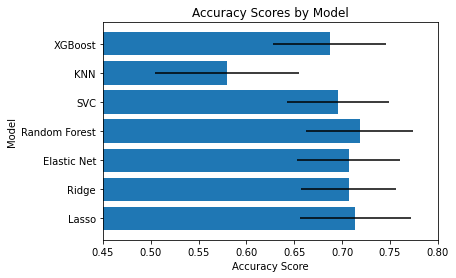

In [99]:
models = ['Lasso', 'Ridge', 'Elastic Net', 'Random Forest', 'SVC', 'KNN', 'XGBoost']
scores_mean = [np.mean(s) for s in all_scores]
scores_stdev = [np.std(s) for s in all_scores]

plt.barh(models, scores_mean)
plt.errorbar(scores_mean, models, xerr=scores_stdev, fmt='none', color='black' )
plt.xlim([0.45,0.8])
plt.xlabel('Accuracy Score')
plt.ylabel('Model')
plt.title('Accuracy Scores by Model')
plt.savefig("../figures/reportfigs/accuracy_scores.png", bbox_inches='tight', dpi=300)
plt.show()

In [100]:
rf_best_params = []

rf_models
for mod in rf_models:
    print(mod.best_params_)
    rf_best_params.append(mod.best_params_)

# save the output
file = open('../results/rf_best_params.save', 'wb')
pickle.dump(rf_best_params,file)
file.close()



{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 0.5}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.5}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.5}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 1, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 1.0}
{'randomforestclassifier__max_depth': 3, 'randomforestclassifier__max_features': 0.75}
{'randomforestclassifier__max_depth': 3, 'randomfo

In [98]:
type(grid.best_estimator_[0])
grid.best_estimator_[0]
list(grid.best_estimator_[0].named_transformers_['onehot'].get_feature_names(onehot_ftrs))

['Gender_F',
 'Gender_M',
 'SES_1.0',
 'SES_2.0',
 'SES_3.0',
 'SES_4.0',
 'SES_5.0',
 'SES_nan']

In [106]:
np.logspace(-3,4,num=8)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])